# Experiment #1 - Baseline Model vs. Baseline ML Models

## Overview

The purpose of this experiment is to establish a baseline for a domain-driven model and to compare it to more sophisticated machine learning models using baseline features. Our baseline model will simply follow our intuited rule:

> Select randomly a customer if they belong to tiers S or A, until we have an amount equivalent to 10% of our dataset (i.e 184), which sounds a reasonable amount of customers to be reached in a certain period of time (campaign).

To estimate the performance of machine learning models, we will train the following models with some different hyperparameter configurations, selecting the best configuration and averaging the scores of the best models:

* Logistic Regression
* SGD Classifier
* XGBoost
* Light GBM
* K-Nearest Neighboors

Scores will be based on how well a classifier can prioritize 184 customers considering the entire database.

In [45]:
%load_ext autoreload
%autoreload 2

from utils import code
from plot_libraries import setup_graphics
from datasets import get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
#Main Libraries
import os, random, re, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data transform (pipeline)
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer


# Model evaluation
import scikitplot as skplt
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict
from evaluation import plot_learning_curve, evaluate_model, plot_confusion_matrix, plot_feature_permutation

# Support
import parameters as params
from model import Model, build_tuned_model
from datasets import get_data
from experiments import experiment_1, get_scorer

#setup
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
sns.set()
%matplotlib inline
setup_graphics()

## Data

In [47]:
X, y = get_data('../data/trainDF.csv')
X.head()

,Activities_Last_30_Days,Employees,ZoomInfo_Employee_Range,ZoomInfo_Revenue_Range,Organic_Visits,Pct_Organic_Visits,SEO_Visits,URLs_Indexed,ZoomInfo_Global_HQ_Country,Annual_Revenue_converted,Adjusted_Industry,Account_ICP_Score,Account_ICP_Tier,Page_Count,Page_Count_Range,Alexa_Rank,Parent_Account_Status
Account_ID,,,,,,,,,,,,,,,,,
0012400000L5cmZ,0.0,10.0,unknown,unknown,61688430.0,0.34,61688430.0,27700000.0,non_US,3.333900e+06,Retail,91.667,Tier A,27700000.0,>1M,331.0,unknown
00124000004sEH5,51.0,10000.0,unknown,unknown,19397082.0,0.93,28615923.0,76200.0,non_US,1.333560e+10,Retail,100.000,Tier A,206300.0,Between 100K and 250K,8881.0,Prospect
00124000004sUGG,0.0,5000.0,unknown,unknown,49283858.0,0.53,50132407.0,12600000.0,non_US,5.556500e+08,Media,100.000,Tier A,12709000.0,>1M,1118.0,Lost Customer
0011p00002SeaiQ,0.0,383.0,250 - 500,$50 mil. - $100 mil.,177515.0,NaN,177515.0,1090000.0,US,7.360000e+07,Classified,70.833,Tier A,1090000.0,>1M,126905.0,unknown
0011p00001SghSL,0.0,5000.0,"1,000 - 5,000",$500 mil. - $1 bil.,8052961.0,0.59,10416602.0,2340000.0,US,2.500000e+08,Classified,100.000,Tier A,3640000.0,>1M,4742.0,Prospect


In [48]:
n_instances = len(X)
p_instances = y.sum() / len(y)
p_targeted = 0.1
n_targeted = int(n_instances*p_targeted)

print('Number of instances: {:,}'.format(n_instances))
print('Number of conversions {:,}'.format(y.sum()))
print('Conversion rate: {:.2f}%'.format(p_instances*100.))
print('Expected number of conversions targeting {:,} @ {:.2f}%: {:,}'.format(n_targeted, p_instances*100., int(p_instances * n_targeted)))

Number of instances: 1,849
Number of conversions 315
Conversion rate: 17.04%
Expected number of conversions targeting 184 @ 17.04%: 31


### Split Dataset

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=20)
n_targeted_test = int(len(X_test) * p_targeted)

### Baseline Model

To evaluate our baseline model, we will include some financial features, which will allow us to compare with ML models later.

In [50]:
# Setup costs and benefits
avg_revenue = params.AVG_REVENUE
avg_cost = params.AVG_COST

In [51]:
# Combine the targeted and random groups
baseline_targets = X_test[X_test.Account_ICP_Tier.isin(['Tier S', 'Tier A'])].sample(n=n_targeted_test, random_state=20)
baseline_ys = y_test.loc[baseline_targets.index]
baseline_outcomes = baseline_ys.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)
assert(len(baseline_targets) == n_targeted_test)

In [52]:
# Create the random targets
random_targets = X_test.sample(n=n_targeted_test)
random_ys = y.loc[random_targets.index]
random_outcomes = random_ys.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)

In [53]:
# Compute profit
random_profit = sum(random_outcomes)
baseline_profit = sum(baseline_outcomes)

print('Number of customers targeted: {:,}/{:,}\n'.format(len(baseline_targets), len(X_test)))

print('Conversion rate under random policy: {:.1f}%'.format(random_ys.sum() / len(random_ys)*100.))
print('Expected profit under random policy: ${:,}\n'.format(random_profit))

print('Conversion rate under baseline policy: {:.3}%'.format(baseline_ys.sum() / len(baseline_ys)*100.))
print('Expected profit under baseline policy: ${:,}'.format(baseline_profit))
print('Lift over random policy: {:.1f} or ${:,}'.format(baseline_profit / random_profit, baseline_profit - random_profit))

Number of customers targeted: 37/370

Conversion rate under random policy: 10.8%
Expected profit under random policy: $3,630

Conversion rate under baseline policy: 35.1%
Expected profit under baseline policy: $12,630
Lift over random policy: 3.5 or $9,000


--------
--------

### Baseline ML models
We will evaluate some ML models and choose the best one under a score function then analyze its predictions and estimate financial impact.

* From exploratory data analysis we noticed that some trasformations are necessary to improve our ML models.

##### Fill nan values

* #1 - fill_value=nan (*only valid to XGB & LGBM*)

```python
num_ct = ColumnTransformer([('numerics', 'passthrough', experiment_1.NUM_FEAT)])
```
--------

* #2 - fill_value=-1, let the model find out a pattern from its own (**best choice**)

```python
num_ct = ColumnTransformer([
    ('fill_diff', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=-1),experiment_1.NUM_FEAT)                          
])
```
--------

* #3 - Multiple heuristics

```python
num_ct_ = ColumnTransformer([
    ('numerics', 'passthrough', pass_feat),
    ('fill_diff',SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1),fill_diff),
    ('fill_max', SimpleImputer(missing_values=np.nan, strategy='most_frequent'),fill_max),
    ('fill_min', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),fill_min)
])
```
-------


#### Creating the pipeline of first experiment

In [54]:
# Create the transformers for categorical features
cat_ct = ColumnTransformer([('categoricals', 'passthrough', experiment_1.CAT_FEAT)])

# Create the pipeline to transform categorical features
cat_pipeline = Pipeline([
        ('cat_ct', cat_ct),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [55]:
# Create the transformers for numeric features
num_ct = ColumnTransformer([
    ('fill_diff', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=-1),experiment_1.NUM_FEAT)                          
])

# Create the pipeline to transform numeric features
num_pipeline = Pipeline([
        ('num_union', num_ct),
        ('scaler', RobustScaler()),
        ('minimax', MinMaxScaler())
])

Concat both pipelines and transform the dataset

In [56]:
pipeline1 = experiment_1.get_pipeline(cat_pipeline, num_pipeline)
experiment_1.save_pipeline(pipeline1, '../models_pkl/experiment-1-pipeline.pkl')

In [57]:
ps = pipeline1.fit_transform(X_train).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 1,479, Features: 63


##### Evaluation Metric

In [58]:
scorer = make_scorer(roc_auc_score)

In [59]:
results=[]

#### ML Models

**Logistic Regression**

In [60]:
from sklearn.linear_model import LogisticRegression
lr_param_grid = {
  'lr__C': np.logspace(-3, 2, 6),
  'lr__intercept_scaling': [1], 
  'lr__max_iter': [100],
  'lr__penalty':  ['l1', 'l2'],
  'lr__solver': ['liblinear'], #good for small datasets
  'lr__tol': [0.0001]
}


#0.653
result = evaluate_model(X_train, y_train, 'lr', 
                        LogisticRegression(), 
                        lr_param_grid, 
                        scorer, n_iter=100, 
                        cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for lr model, 1479 examples
==> Elapsed seconds: 6.565
Best lr model: LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Best lr score: 0.653


**XGBoost**

In [61]:
from xgboost import XGBClassifier
xgb_param_grid = {
        'xgb__colsample_bylevel' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
        'xgb__colsample_bytree' :[0.6, 0.7, 0.8, 1.0],
        'xgb__gamma' : list(np.linspace(0.05, 1, 6)),
        'xgb__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'xgb__max_depth' : list(range(3, 30, 3)),
        'xgb__min_child_weight' : list(range(1, 11, 2)),
        'xgb__n_estimators' : list(range(50, 400, 50)),
        'xgb__reg_alpha' : list(np.logspace(-1, 1, num=10)/10),
        'xgb__reg_lambda' : list(np.logspace(-1, 1, num=10)/10),
        'xgb__subsample' : [0.6, 0.7, 0.8, 1.0]
}

#0.753
result = evaluate_model(X_train, y_train, 'xgb', 
                        XGBClassifier(), 
                        xgb_param_grid, 
                        scorer, n_iter=100, 
                        cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for xgb model, 1479 examples
==> Elapsed seconds: 132.596
Best xgb model: XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.24, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.04641588833612779, reg_lambda=0.12915496650148842,
              scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)
Best xgb score: 0.753


**Light GBM**

In [62]:
from lightgbm import LGBMClassifier
lgbm_param_grid = {
    'lgbm__boosting_type': ['gbdt', 'goss', 'dart'],
    'lgbm__num_leaves': list(range(20, 150)),
    'lgbm__learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'lgbm__subsample_for_bin': list(range(20000, 300000, 20000)),
    'lgbm__min_child_samples': list(range(20, 500, 5)),
    'lgbm__reg_alpha': list(np.linspace(0, 1)),
    'lgbm__reg_lambda': list(np.linspace(0, 1)),
    'lgbm__colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'lgbm__subsample': list(np.linspace(0.5, 1, 100)),
    'lgbm__is_unbalance': [True, False]
}

#0.808
result = evaluate_model(X_train, y_train, 'lgbm', 
                        LGBMClassifier(), 
                        lgbm_param_grid, 
                        scorer, n_iter=100, 
                        cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for lgbm model, 1479 examples
==> Elapsed seconds: 27.326
Best lgbm model: LGBMClassifier(boosting_type='dart', class_weight=None,
               colsample_bytree=0.6888888888888889, importance_type='split',
               is_unbalance=True, learning_rate=0.09555453108445688,
               max_depth=-1, min_child_samples=160, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=58,
               objective=None, random_state=None, reg_alpha=0.26530612244897955,
               reg_lambda=0.7755102040816326, silent=True,
               subsample=0.6818181818181819, subsample_for_bin=280000,
               subsample_freq=0)
Best lgbm score: 0.808


**SGD Classifier**

In [63]:
from sklearn.linear_model import SGDClassifier
sgd_param_grid = {
  'sgd__alpha' : np.logspace(-4, 3, 8), 
  'sgd__loss' : ['log'], #['log','hinge'],
  'sgd__max_iter' : [1000],  
  'sgd__n_jobs' : [-1], 
  'sgd__penalty' : ['l2', 'l1', 'elasticnet'],
  'sgd__tol' : [0.001],
}

#0.678
result = evaluate_model(X_train, y_train, 'sgd', 
                        SGDClassifier(), 
                        sgd_param_grid, 
                        scorer, n_iter=100, 
                        cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for sgd model, 1479 examples
==> Elapsed seconds: 3.118
Best sgd model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best sgd score: 0.678


**K-Nearest Neighboors**

In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn_param_grid =  {
  'knn__leaf_size' : list(range(2, 40, 2)), 
  'knn__metric' : ['euclidean', 'manhattan'],
  'knn__n_neighbors' : list(range(2, 18, 2)), 
  'knn__p' : [2,3],
  'knn__weights' : ['uniform', 'distance']
}

#0.566
result = evaluate_model(X_train, y_train, 'knn', 
                        KNeighborsClassifier(), 
                        knn_param_grid, 
                        scorer, n_iter=100, 
                        cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for knn model, 1479 examples
==> Elapsed seconds: 68.934
Best knn model: KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')
Best knn score: 0.566


### Comparing results
The table shows the mean and variance performed by the ML models

In [65]:
pd.DataFrame.from_dict(list(map(lambda x:
                      {'model': x[1], 'mean': x[2], 'std': x[3] }, results)))[[
                       'model', 'mean', 'std'
                      ]].sort_values('mean', ascending=False)#.style.bar()

,model,mean,std
2,lgbm,0.808167,0.020024
1,xgb,0.753468,0.023617
3,sgd,0.677526,0.050557
0,lr,0.653349,0.030340
4,knn,0.566066,0.042427


The best model was **Light GBM**. We will save it to use later on.

In [66]:
model_result = list(filter(lambda x: x[1] == 'lgbm', results))[0]
model = model_result[0]
print('Best model performance mean:', model_result[2])
print('Best model performance std:', model_result[3])
#model.save('../models_pkl/experiment-1-model.pkl')

Best model performance mean: 0.8081669155467065
Best model performance std: 0.020024071498969502


--------------
-------------

### Analyzing best model

In [67]:
model = Model.load('../models_pkl/experiment-1-model.pkl')
model.model

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9555555555555555, importance_type='split',
               is_unbalance=True, learning_rate=0.0381814913064112,
               max_depth=-1, min_child_samples=60, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=71,
               objective=None, random_state=None,
               reg_alpha=0.061224489795918366, reg_lambda=0.5714285714285714,
               silent=True, subsample=0.7070707070707071,
               subsample_for_bin=140000, subsample_freq=0)

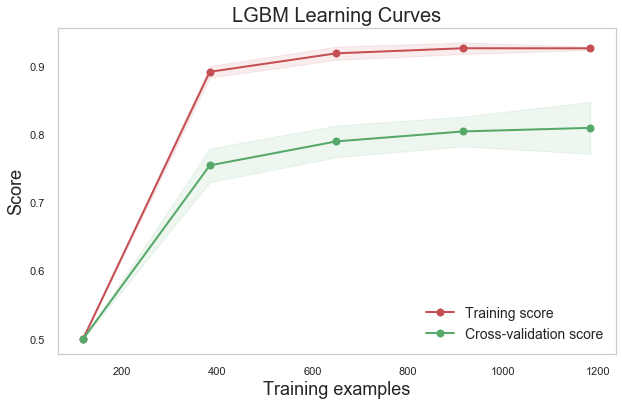

In [68]:
#model_result = list(filter(lambda x: x[1] == 'lgbm', results))[0]
#model = model_result[0]
plot_learning_curve(model.model, 
                    model.name.upper()+' Learning Curves',
                    model.pipeline.fit_transform(X_train), y_train,
                    cv=5, scoring=scorer)

We can see that our best model performs worst than a random model when we have only 10% of our data (i.e AUC=0.5), however the performance comes better as the dataset size increase, reaching a good AUC = 0.8.

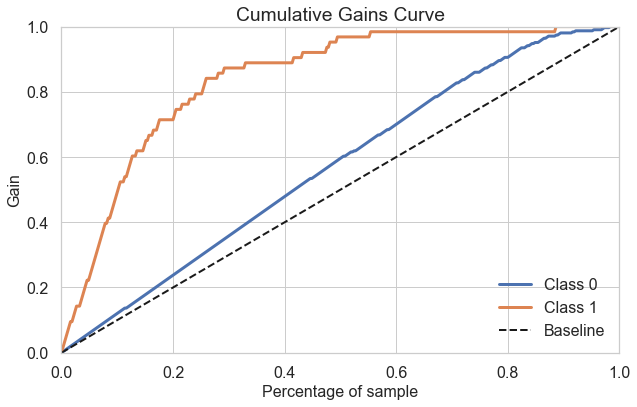

In [69]:
preds = model.model.predict(model.pipeline.transform(X_test))
probs = model.model.predict_proba(model.pipeline.transform(X_test))

_ = skplt.metrics.plot_cumulative_gain(y_test, probs)

The cumulative gains curve is an evaluation curve that assesses the performance of the model and compares the results with the random pick. It shows the percentage of targets reached when considering a certain percentage of the population (20%) with the highest probability to be target according to the model (70%).

              precision    recall  f1-score   support

           0       0.95      0.86      0.91       307
           1       0.54      0.79      0.65        63

    accuracy                           0.85       370
   macro avg       0.75      0.83      0.78       370
weighted avg       0.88      0.85      0.86       370



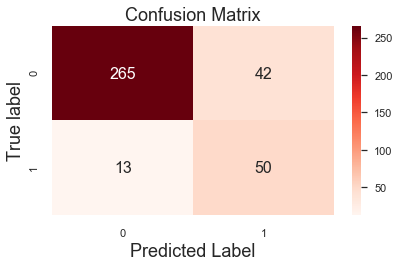

In [70]:
plot_confusion_matrix(y_test, preds)

While our model isn't very precise (we are correct in predicting a conversion 54% of the time, 46% of the time we get a false positive), it does a very good job (compared to random guessing) at finding customers that are likely to convert.

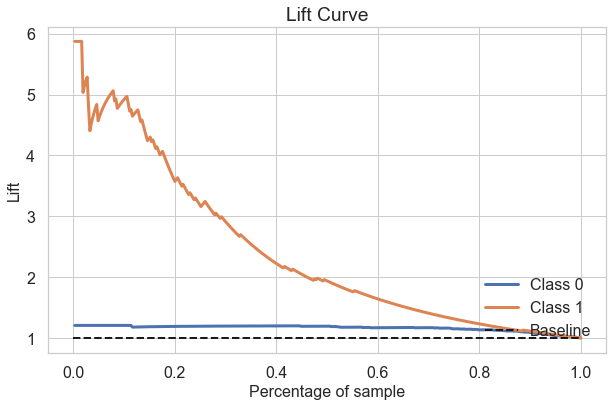

In [71]:
_ = skplt.metrics.plot_lift_curve(y_test, probs)

On the vertical axis, the lift curve indicates how many times more than average targets are included in this group. If we are targeting 10% of the population, we have 5 times more chance to find a target sample.

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.84      1.00      0.91        31

    accuracy                           0.84        37
   macro avg       0.42      0.50      0.46        37
weighted avg       0.70      0.84      0.76        37



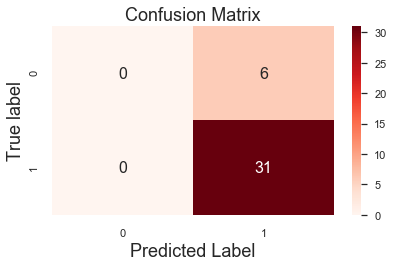

In [72]:
# Create a dataframe of probabilities and actual / predicted outcomes
probs_df = pd.DataFrame(np.hstack([probs, y_test.values.reshape(-1,1), preds.reshape(-1,1)]), 
                        columns=['p_no', 'p_yes', 'actual', 'predicted'])


# Sort customers by the probability that they will convert
model_targets = probs_df.sort_values('p_yes', ascending=False)

# Take the top 10%
model_targets = model_targets.head(n_targeted_test)

# Calculate precision matrix
plot_confusion_matrix(model_targets.actual, model_targets.predicted)

Picking the top 10% fo our model prediction, the precision goes up to 84%. Which sounds a good job.

### Financial Impact of the Best Model

In [73]:
# Calculate financial outcomes
model_outcomes = model_targets.actual.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)

# Calculate profit
model_profit = sum(model_outcomes)

print('Number of customers targeted: {:,}/{:,}'.format(len(model_targets), len(X_test)))
print('Conversion rate of model policy: {:.2f}%'.format(model_targets.actual.sum() / len(model_outcomes)*100.))
print('Expected profit of model policy: ${:,}'.format(model_profit))
print('Lift over random: {:.1f} or ${:,}'.format(model_profit / random_profit, model_profit - random_profit))
print('Lift over baseline: {:.1f} or ${:,}'.format(model_profit / baseline_profit, model_profit - baseline_profit))

Number of customers targeted: 37/370
Conversion rate of model policy: 83.78%
Expected profit of model policy: $30,630
Lift over random: 8.4 or $27,000
Lift over baseline: 2.4 or $18,000


If we wanted to reduce the number of false positives, we could choose a probability threshold that corresponds to a lower (FPR, TPR) point on the ROC curve but assuming our profit margin is high (assuming that our cost and revenue estimatios are correct), then we can afford the misclassifications so long as the classifier does a good job of selecting customers who end up converting.